# Mass Definitions

``hmf``, as of v3.1, provides a simple way of converting between halo mass definitions, which serves two basic purposes:

1. the mass of a halo in one definition can be converted to its appropriate mass under another definition
2. the halo mass function can be converted between mass definitions.

## Introduction

By "mass definition" we mean the way the extent of a halo is defined. In ``hmf``, we support two main kinds of definition, which themselves can contain different models. In brief, ``hmf`` supports Friends-of-Friends (FoF) halos, which are defined via their linking length, $b$, and spherical-overdensity (SO) halos, which are defined by two criteria: an overdensity $\Delta_h$, and an indicator of what that overdensity is with respect to (usually mean background density $\rho_m$, or critical density $\rho_c$). In addition to being able to provide a precise overdensity for a SO halo, ``hmf`` provides a way to use the so-called "virial" overdensity, as defined in Bryan and Norman (1998). 

Converting between SO mass definitions is relatively simple: given a halo profile and concentration for the given halo mass, determine the concentration required to make that profile contain the desired density, and then compute the mass of the halo under such a concentration. 

There is no clear way to perform such a conversion for FoF halos. Nevertheless, if one assumes that all linked particles are the same mass, and that halos are spherical and singular isothermal spheres (cf. White (2001)), one can approximate an FoF halo by an SO halo of density $9 \rho_m /(2\pi b^3)$. ``hmf`` will make this approximation if a conversion between mass definitions is desired.

## Changing Mass Definitions

Most of the functionality concerning mass definitions is defined in the ``hmf.halos.mass_definitions`` module: 

In [1]:
import hmf
from hmf.halos import mass_definitions as md

print("Using hmf version v%s"%hmf.__version__)

Using hmf version v3.3.4.dev14+g9a9b63c.d20210610


While we're at it, import matplotlib and co:

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import inspect

Different mass definitions exist inside the ``mass_definitions`` module as ``Components``. All definitions are subclassed from the abstract ``MassDefinition`` class:

In [3]:
[x[1] for x in inspect.getmembers(md, inspect.isclass) if issubclass(x[1], md.MassDefinition)]

[hmf.halos.mass_definitions.FOF,
 hmf.halos.mass_definitions.MassDefinition,
 hmf.halos.mass_definitions.SOCritical,
 hmf.halos.mass_definitions.SOGeneric,
 hmf.halos.mass_definitions.SOMean,
 hmf.halos.mass_definitions.SOVirial,
 hmf.halos.mass_definitions.SphericalOverdensity]

### The Mass Definition Component

To create an instance of any class, optional ``cosmo`` and ``z`` arguments can be specified. By default, these are the ``Planck15`` cosmology at redshift 0. We'll leave them as default for this example. Let's define two mass definitions, both spherical-overdensity definitions with respect to the mean background density:

In [4]:
mdef_1 = md.SOMean(overdensity=200)
mdef_2 = md.SOMean(overdensity=500)

Each mass definition has its own ``model_parameters``, which define the exact overdensity. For both the ``SOMean`` and ``SOCritical`` definitions, the ``overdensity`` can be provided, as above (default is 200). This must be passed as a named argument. For the ``FOF`` definition, the ``linking_length`` can be passed (default 0.2). For the ``SOVirial``, no parameters are available. Available parameters and their defaults can be checked the same way as *any* ``Component`` within ``hmf``:

In [5]:
md.SOMean._defaults

{'overdensity': 200}

The explicit halo density for a given mass definition can be accessed:

In [6]:
mdef_1.halo_density(), mdef_1.halo_density()/mdef_1.mean_density()

(17068502575484.854, 200.0)

### Converting Masses

To convert a mass in one definition to a mass in another, use the following:

In [7]:
mnew, rnew, cnew = mdef_1.change_definition(m=1e12, mdef=mdef_2)
print("Mass in new definition is %.2f x 10^12 Msun / h"%(mnew/1e12))
print("Radius of halo in new definition is %.2f Mpc/h"%rnew)
print("Concentration of halo in new definition is %.2f"%cnew)

Mass in new definition is 0.76 x 10^12 Msun / h
Radius of halo in new definition is 0.16 Mpc/h
Concentration of halo in new definition is 4.81


/home/steven/miniconda3/envs/hmf/lib/python3.7/site-packages/halomod/halo_exclusion.py:17: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  "Warning: Some Halo-Exclusion models have significant speedup when using Numba"


The input mass argument can be a list or array of masses also. To convert between masses, the concentration of the input halos, and their density profile, must be known. By default, an NFW profile is assumed, with a concentration-mass relation from Duffy et al. (2008).

One can alternatively pass a concentration directly:

In [8]:
mnew, rnew, cnew = mdef_1.change_definition(m=1e12, mdef=mdef_2, c = 5.0)
print("Mass in new definition is %.2f x 10^12 Msun / h"%(mnew/1e12))
print("Radius of halo in new definition is %.2f Mpc/h"%rnew)
print("Concentration of halo in new definition is %.2f"%cnew)

Mass in new definition is 0.72 x 10^12 Msun / h
Radius of halo in new definition is 0.16 Mpc/h
Concentration of halo in new definition is 3.31


If you have ``halomod`` installed, you can also pass any ``halomod.profiles.Profile`` instance (which itself includes a concentration-mass relation) as the ``profile`` argument.

### Converting Mass Functions

All halo mass function fits are measured using halos found using some halo definition. While some fits explicitly include a parameterization for the spherical overdensity of the halo (eg. ``Tinker08``, ``Watson`` and ``Bocquet``), others do not.

By passing a mass definition to the ``MassFunction`` constructor, ``hmf`` can attempt to convert the mass function defined by the chosen fitting function to the appropriate mass definition, using ([Bocquet et al, 2016](http://adsabs.harvard.edu/abs/2016MNRAS.456.2361B)):

\begin{equation}
    \frac{dn}{dm'} = \frac{dn}{dm}\frac{dm}{dm'} = f(\nu)\frac{\rho_0}{m'}\frac{d\nu}{dm'} \times \frac{m'}{m}
\end{equation}

where the last factor captures all the evolution with mass definition. You should note that this is only ever approximate -- it doesn't account for scatter in the profile of individual halos, nor does it preserve the halo model condition that all mass resides in halos (even if the original mass function did). In effect, the new $m'/m$ term is modifying the $f(\nu)$.

By default, the mass definition is ``None``, which uses whatever mass definition was employed by the chosen fit.  Nevertheless, care should be taken here: many of the different fits have different mass definitions, and should not be compared without some form of mass conversion (and possibly not even then). To see the mass definition intrinsic to the measurement of each fit, use the following:

In [9]:
from hmf.mass_function.fitting_functions import SMT, Tinker08, Jenkins

In [10]:
print(SMT.sim_definition.halo_finder_type, SMT.sim_definition.halo_overdensity)
print(Tinker08.sim_definition.halo_finder_type, Tinker08.sim_definition.halo_overdensity)
print(Jenkins.sim_definition.halo_finder_type, Jenkins.sim_definition.halo_overdensity)


SO vir
SO *(200m)
FoF 0.2


Here "vir" corresponds to the virial definition of Bryan and Norman (1998), an asterisk indicates that the fit is itself parameterized for SO mass definitions, and 0.2 is the FoF linking length.

Let's convert the mass definition of ``Tinker08``, which has an intrinsic parameterization:

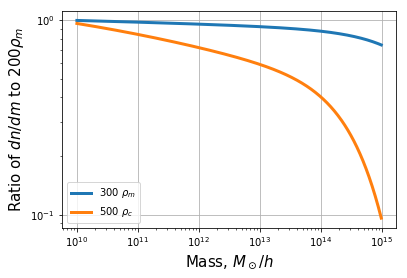

In [11]:
# Default mass function object
mf = hmf.MassFunction()

dndm0 = mf.dndm

# Change the mass definition to 300rho_mean
mf.update(
    mdef_model  = "SOMean", 
    mdef_params = {
        "overdensity": 300 
    }
)

plt.plot(mf.m, mf.dndm/dndm0, label=r"300 $\rho_m$", lw=3)

# Change the mass definition to 500rho_crit
mf.update(
    mdef_model  = "SOCritical", 
    mdef_params = {
        "overdensity": 500 
    }
)

plt.plot(mf.m, mf.dndm/dndm0, label=r"500 $\rho_c$", lw=3)

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"Mass, $M_\odot/h$", fontsize=15)
plt.ylabel(r"Ratio of $dn/dm$ to $200 \rho_m$", fontsize=15)
plt.grid(True)
plt.legend();

This did not require any internal conversion, since the `Tinker08` function is able to deal natively with multiple definitions. Let's try converting a fit that has no explicit parameterization for overdensity:

/home/steven/Documents/Projects/halos/HMF/hmf/src/hmf/mass_function/hmf.py:274: UserWarning: Your input mass definition 'SOMean(300)' does not match the mass definition in which the hmf fit SMT was measured:'SOVirial'. The mass function will be converted to your input definition, but note that some properties do not survive the conversion, eg. the integral of the hmf over mass yielding the total mean density.
  f"Your input mass definition '{mdef}' does not match the mass "
/home/steven/Documents/Projects/halos/HMF/hmf/src/hmf/mass_function/hmf.py:274: UserWarning: Your input mass definition 'SOCritical(500)' does not match the mass definition in which the hmf fit SMT was measured:'SOVirial'. The mass function will be converted to your input definition, but note that some properties do not survive the conversion, eg. the integral of the hmf over mass yielding the total mean density.
  f"Your input mass definition '{mdef}' does not match the mass "


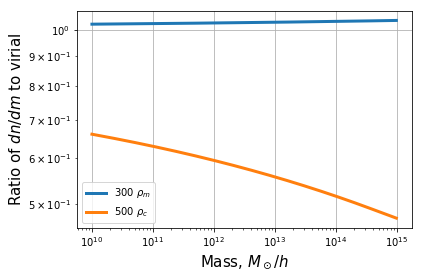

In [12]:
# Default mass function object.
mf = hmf.MassFunction(hmf_model = "SMT", Mmax=15, disable_mass_conversion=False)
dndm0 = mf.dndm

# Change the mass definition to 300rho_mean
mf.update(
    mdef_model  = "SOMean", 
    mdef_params = {
        "overdensity": 300 
    }
)
plt.plot(mf.m, mf.dndm/dndm0, label=r"300 $\rho_m$", lw=3)


# Change the mass definition to 500rho_crit
mf.update(
    mdef_model  = "SOCritical", 
    mdef_params = {
        "overdensity": 500 
    }
)
plt.plot(mf.m, mf.dndm/dndm0, label=r"500 $\rho_c$", lw=3)

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"Mass, $M_\odot/h$", fontsize=15)
plt.ylabel(r"Ratio of $dn/dm$ to virial", fontsize=15)
plt.grid(True)
plt.legend();

Here, the measured mass function uses "virial" halos, which have an overdensity of ~330$\rho_m$, so that converting to 300$\rho_m$ is a down-conversion of density. Finally, we convert a FoF mass function:

/home/steven/Documents/Projects/halos/HMF/hmf/src/hmf/mass_function/hmf.py:274: UserWarning: Your input mass definition 'FoF(l=0.3)' does not match the mass definition in which the hmf fit Jenkins was measured:'FoF(l=0.2)'. The mass function will be converted to your input definition, but note that some properties do not survive the conversion, eg. the integral of the hmf over mass yielding the total mean density.
  f"Your input mass definition '{mdef}' does not match the mass "
/home/steven/Documents/Projects/halos/HMF/hmf/src/hmf/mass_function/hmf.py:274: UserWarning: Your input mass definition 'SOVirial' does not match the mass definition in which the hmf fit Jenkins was measured:'FoF(l=0.2)'. The mass function will be converted to your input definition, but note that some properties do not survive the conversion, eg. the integral of the hmf over mass yielding the total mean density.
  f"Your input mass definition '{mdef}' does not match the mass "


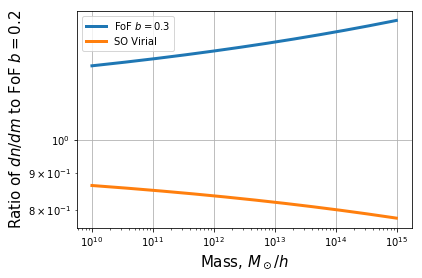

In [13]:
# Default mass function object.
mf = hmf.MassFunction(hmf_model = "Jenkins", disable_mass_conversion=False)
dndm0 = mf.dndm

# Change the mass definition to 300rho_mean
mf.update(
    mdef_model  = "FOF", 
    mdef_params = {
        "linking_length": 0.3 
    }
)
plt.plot(mf.m, mf.dndm/dndm0, label=r"FoF $b=0.3$", lw=3)


# Change the mass definition to 500rho_crit
mf.update(
    mdef_model  = "SOVirial",
    mdef_params = {}   # NOTE: we need to pass an empty dict here 
                       # so that the "linking_length" argument is removed.
)
plt.plot(mf.m, mf.dndm/dndm0, label=r"SO Virial", lw=3)

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"Mass, $M_\odot/h$", fontsize=15)
plt.ylabel(r"Ratio of $dn/dm$ to FoF $b=0.2$", fontsize=15)
plt.grid(True)
plt.legend();

To see the difference between an assumed mass conversion and a properly re-fit mass function, we can compute an automatically-converted mass function for `Bocquet2016`, and compare to the refit:

/home/steven/Documents/Projects/halos/HMF/hmf/src/hmf/mass_function/hmf.py:274: UserWarning: Your input mass definition 'SOCritical(200)' does not match the mass definition in which the hmf fit Bocquet200mDMOnly was measured:'SOMean(200.0)'. The mass function will be converted to your input definition, but note that some properties do not survive the conversion, eg. the integral of the hmf over mass yielding the total mean density.
  f"Your input mass definition '{mdef}' does not match the mass "
/home/steven/Documents/Projects/halos/HMF/hmf/src/hmf/mass_function/hmf.py:274: UserWarning: Your input mass definition 'SOCritical(500)' does not match the mass definition in which the hmf fit Bocquet200mDMOnly was measured:'SOMean(200.0)'. The mass function will be converted to your input definition, but note that some properties do not survive the conversion, eg. the integral of the hmf over mass yielding the total mean density.
  f"Your input mass definition '{mdef}' does not match the mas

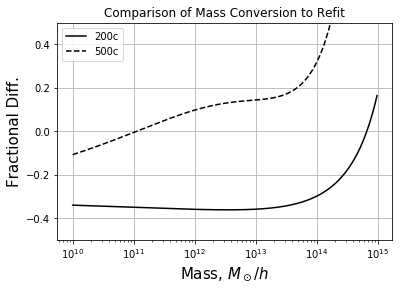

In [19]:
# Default mass function object.
mf = hmf.MassFunction(hmf_model = "Bocquet200mDMOnly", mdef_model='SOCritical', mdef_params={'overdensity': 200}, disable_mass_conversion=False)
mf2 = hmf.MassFunction(hmf_model = "Bocquet200cDMOnly")
mf3 = hmf.MassFunction(hmf_model = "Bocquet500cDMOnly")

fig, ax = plt.subplots(1, 1, sharex=True)
ax = [ax]
ax[0].plot(mf.m, mf.dndm/mf2.dndm - 1, color='k', label='200c')

mf.update(mdef_params={"overdensity": 500})
ax[0].plot(mf.m, mf.dndm/mf3.dndm - 1, ls='--', color='k', label='500c')

ax[0].set_xscale('log')
ax[0].set_xlabel(r"Mass, $M_\odot/h$", fontsize=15)
ax[0].set_ylabel(r"dn/dm", fontsize=15)
ax[0].grid(True)
ax[0].legend();

ax[0].set_ylim(-0.5, 0.5)
ax[0].set_ylabel("Fractional Diff.")
ax[0].set_title("Comparison of Mass Conversion to Refit");
plt.savefig("/home/steven/Desktop/comparison_of_massconv_to_refit.pdf")

We see that the conversion is only accurate to ~40% at lower masses, and blows up at high masses.